# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

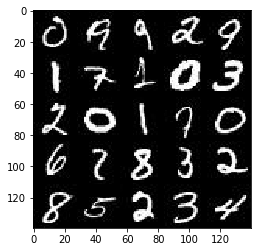

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

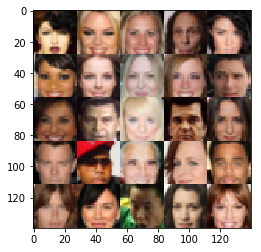

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, 
                                             image_width, 
                                             image_height, 
                                             image_channels), 
                                name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim),
                             name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
from tensorflow.contrib.layers.python.layers import initializers

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    #  -0.5 to 0.5 of 28x28 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.contrib.layers.conv2d(images, 64, 5, 
                                      stride=2, padding='same',
                                      weights_initializer=initializers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.contrib.layers.conv2d(relu1, 128, 5, 
                                      stride=2, padding='same',
                                      weights_initializer=initializers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.contrib.layers.conv2d(relu2, 256, 5, 
                                      stride=2, padding='same',
                                      weights_initializer=initializers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 64))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512
        
        x2 = tf.layers.conv2d_transpose(x1, 32, 4,
                                        strides=1, 
                                        use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 16, 5, 
                                        strides=2, 
                                        padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, 
                                            out_channel_dim, 
                                            5,
                                            strides=2, 
                                            padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
    
    # Return the 28x28xout_channel_dim images
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars 
              if var.name.startswith('discriminator')]
    g_vars = [var for var in trainable_vars
              if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(d_loss,
                                                                  var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(g_loss,
                                                                   var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # print(batch_size) # 128
    # print(z_dim) # 100
    # print(data_shape) # (60000, 28, 28, 1)
    # print(data_image_mode) # L
    if (data_image_mode == 'L'):
        image_channels = 1
    elif (data_image_mode == 'RGB'):
        image_channels = 3
        
    print_every = 20
    show_every = 100

    class GAN:
        def __init__(self, image_width, image_height, image_channels,
                     z_dim, learning_rate, beta1=0.5):
            self.input_real, self.input_z, self.learning_rate = model_inputs(image_width,
                                                                             image_height,
                                                                             image_channels,
                                                                             z_dim)
            self.d_loss, self.g_loss = model_loss(self.input_real,
                                                  self.input_z,
                                                  image_channels)
            self.d_opt, self.g_opt = model_opt(self.d_loss,
                                               self.g_loss,
                                               self.learning_rate,
                                               beta1)

    samples, losses = [], []
    steps = 0
    gan = GAN(data_shape[1], data_shape[2], image_channels,
              z_dim, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,
                                                         z_dim))
                
                # Run optimizers
                _ = sess.run(gan.d_opt, feed_dict={gan.input_real: batch_images,
                                                   gan.input_z: batch_z,
                                                   gan.learning_rate: learning_rate})
                _ = sess.run(gan.g_opt, feed_dict={gan.input_real: batch_images,
                                                   gan.input_z: batch_z,
                                                   gan.learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each print_every epoch, get the losses & print them out
                    train_loss_d = gan.d_loss.eval({gan.input_real: batch_images,
                                                    gan.input_z: batch_z})
                    train_loss_g = gan.g_loss.eval({gan.input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    print(batch_images.shape)
                    show_generator_output(sess, 10, gan.input_z, 
                                          image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 4.6534
Epoch 1/2... Discriminator Loss: 0.3554... Generator Loss: 6.7684
Epoch 1/2... Discriminator Loss: 0.4880... Generator Loss: 3.4933
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 9.9472
Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 3.1872
(64, 28, 28, 1)


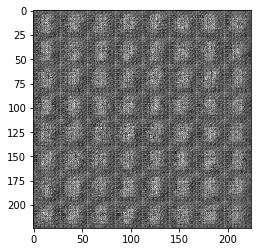

Epoch 1/2... Discriminator Loss: 0.3503... Generator Loss: 4.6760
Epoch 1/2... Discriminator Loss: 6.3857... Generator Loss: 0.0056
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 4.2508
Epoch 1/2... Discriminator Loss: 0.3664... Generator Loss: 4.4697
Epoch 1/2... Discriminator Loss: 0.3503... Generator Loss: 4.5230
(64, 28, 28, 1)


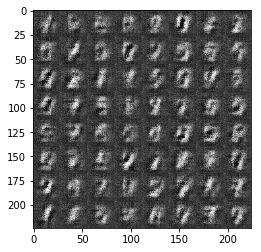

Epoch 1/2... Discriminator Loss: 0.4514... Generator Loss: 2.9353
Epoch 1/2... Discriminator Loss: 0.3974... Generator Loss: 3.5091
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 3.2587
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 2.5597
Epoch 1/2... Discriminator Loss: 0.3954... Generator Loss: 3.2501
(64, 28, 28, 1)


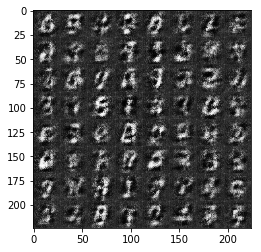

Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 4.0380
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 4.6546
Epoch 1/2... Discriminator Loss: 0.3644... Generator Loss: 3.8467
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 4.9841
Epoch 1/2... Discriminator Loss: 0.4720... Generator Loss: 2.3673
(64, 28, 28, 1)


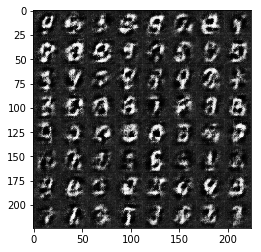

Epoch 1/2... Discriminator Loss: 0.4201... Generator Loss: 2.8492
Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 4.2547
Epoch 1/2... Discriminator Loss: 0.4768... Generator Loss: 3.0611
Epoch 1/2... Discriminator Loss: 0.3996... Generator Loss: 3.0154
Epoch 1/2... Discriminator Loss: 0.4179... Generator Loss: 3.0272
(64, 28, 28, 1)


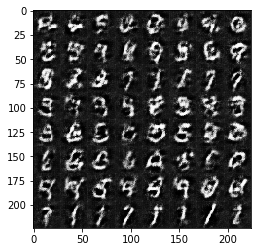

Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 4.4732
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 2.8632
Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 3.9465
Epoch 1/2... Discriminator Loss: 2.2003... Generator Loss: 0.3396
Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 2.5530
(64, 28, 28, 1)


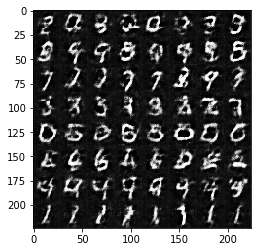

Epoch 1/2... Discriminator Loss: 0.4338... Generator Loss: 3.9360
Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 2.6754
Epoch 1/2... Discriminator Loss: 0.4370... Generator Loss: 2.9026
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 4.6247
Epoch 1/2... Discriminator Loss: 0.4160... Generator Loss: 3.5888
(64, 28, 28, 1)


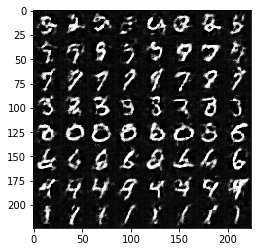

Epoch 1/2... Discriminator Loss: 0.5227... Generator Loss: 2.1312
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 2.1529
Epoch 1/2... Discriminator Loss: 0.6088... Generator Loss: 3.3859
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 3.8815
Epoch 1/2... Discriminator Loss: 0.4520... Generator Loss: 2.9523
(64, 28, 28, 1)


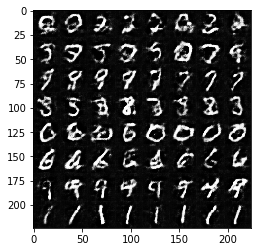

Epoch 1/2... Discriminator Loss: 0.4914... Generator Loss: 2.9181
Epoch 1/2... Discriminator Loss: 0.7033... Generator Loss: 1.5499
Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 0.4631... Generator Loss: 2.5663
Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 2.6071
(64, 28, 28, 1)


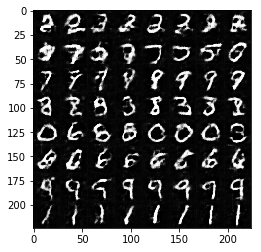

Epoch 1/2... Discriminator Loss: 0.4675... Generator Loss: 2.9794
Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 2.0070
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.3264
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 1.1071
Epoch 2/2... Discriminator Loss: 0.5083... Generator Loss: 2.7407
(64, 28, 28, 1)


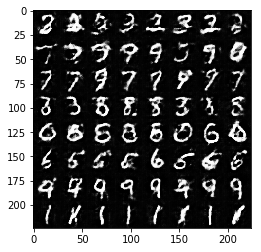

Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.8987
Epoch 2/2... Discriminator Loss: 0.5902... Generator Loss: 1.8116
Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 1.6739
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.7627
(64, 28, 28, 1)


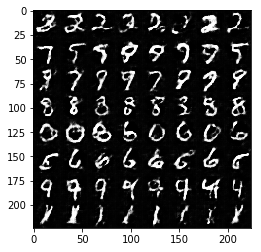

Epoch 2/2... Discriminator Loss: 0.6413... Generator Loss: 2.9692
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.0770
(64, 28, 28, 1)


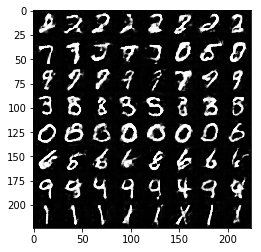

Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 1.8259
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 2.5823
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 1.6035
Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.8891
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 2.3644
(64, 28, 28, 1)


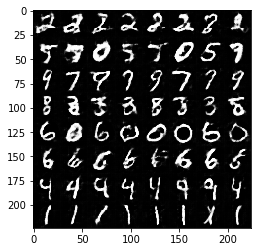

Epoch 2/2... Discriminator Loss: 2.2672... Generator Loss: 4.3940
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.7744
Epoch 2/2... Discriminator Loss: 0.5507... Generator Loss: 2.1129
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 2.3569
Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 2.1622
(64, 28, 28, 1)


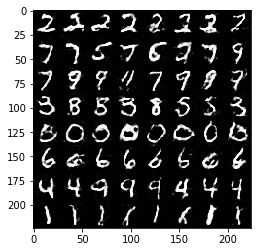

Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.9685
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 2.1044
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 2.0226
Epoch 2/2... Discriminator Loss: 0.5139... Generator Loss: 2.3660
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.3595
(64, 28, 28, 1)


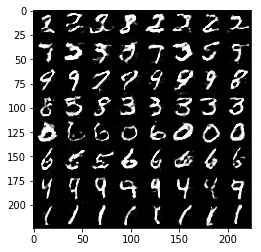

Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 2.0387
Epoch 2/2... Discriminator Loss: 0.6047... Generator Loss: 1.8341
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.6764
Epoch 2/2... Discriminator Loss: 0.5848... Generator Loss: 2.2846
(64, 28, 28, 1)


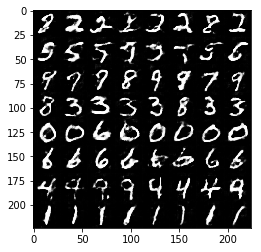

Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.9749
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 2.2621
Epoch 2/2... Discriminator Loss: 0.6698... Generator Loss: 1.6166
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 2.2628
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 1.5760
(64, 28, 28, 1)


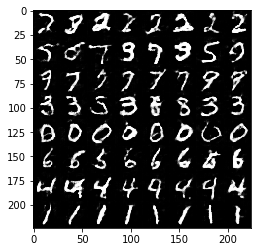

Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.6347
Epoch 2/2... Discriminator Loss: 0.6193... Generator Loss: 2.0548
Epoch 2/2... Discriminator Loss: 0.5807... Generator Loss: 2.0723
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.2574
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.5706
(64, 28, 28, 1)


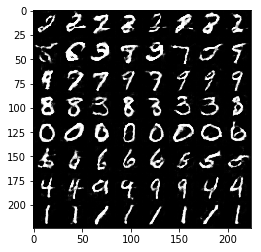

Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 3.6152
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 2.2685
Epoch 2/2... Discriminator Loss: 0.6057... Generator Loss: 2.3838


In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, 
          mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.7278
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 5.0532
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 3.9950
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 5.9217
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 5.2518
(64, 28, 28, 3)


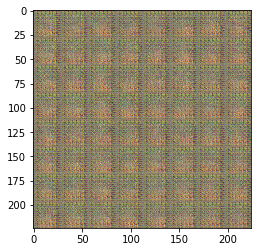

Epoch 1/1... Discriminator Loss: 0.3495... Generator Loss: 6.6301
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 6.2468
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 3.0451
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.1679
Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 5.9912
(64, 28, 28, 3)


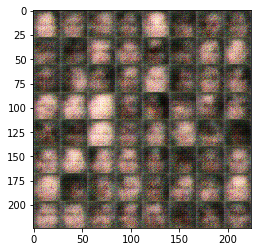

Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 3.7695
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 3.3974
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 3.8414
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 4.0531
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 4.4900
(64, 28, 28, 3)


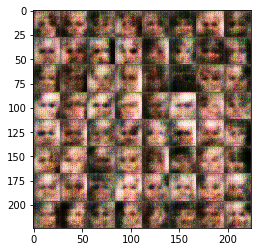

Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 4.1591
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 3.9574
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 4.6334
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 5.9174
Epoch 1/1... Discriminator Loss: 3.8916... Generator Loss: 0.0699
(64, 28, 28, 3)


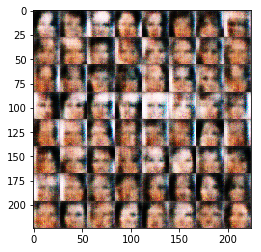

Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.7925
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 4.9520
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 4.9159
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.9993
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 3.7453
(64, 28, 28, 3)


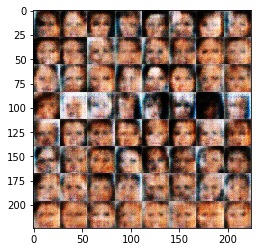

Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 3.5103
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 5.1452
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 4.0725
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 2.3924
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 4.1041
(64, 28, 28, 3)


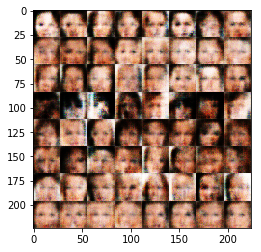

Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.4273
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 4.1959
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 2.8123
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 3.0284
(64, 28, 28, 3)


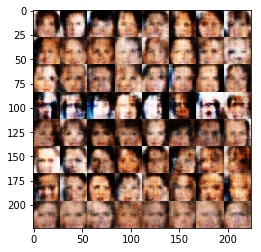

Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 3.8559
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 2.9610
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 3.9609
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.4285
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.2809
(64, 28, 28, 3)


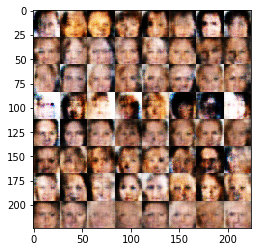

Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 3.4627
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 3.8844
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 3.3464
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 2.9260
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 2.7876
(64, 28, 28, 3)


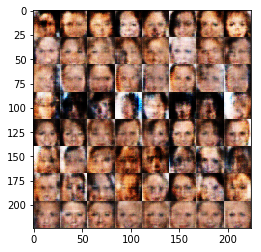

Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 2.5432
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.8666
Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 0.4169... Generator Loss: 3.3537
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 4.8287
(64, 28, 28, 3)


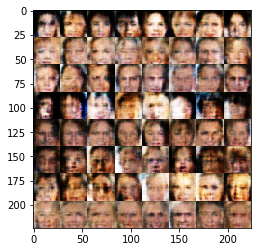

Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.9915
Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 3.8708
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.6267
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.4165
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 2.9906
(64, 28, 28, 3)


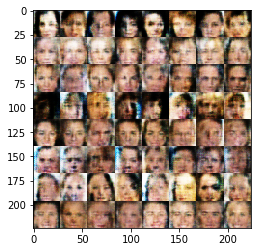

Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 2.5719
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 2.7329
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.6494
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 3.1911
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.0736
(64, 28, 28, 3)


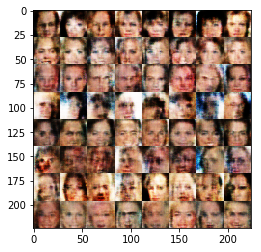

Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.4026
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.7367
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 3.1991
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 2.0720
(64, 28, 28, 3)


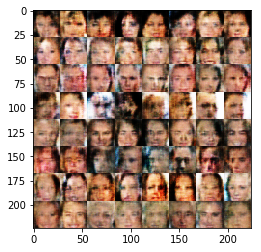

Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 2.0476
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 3.0881
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 2.8235
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.2147
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.4979
(64, 28, 28, 3)


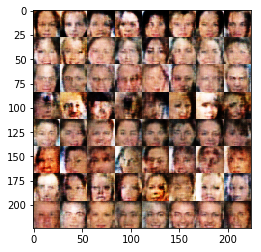

Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 2.9969
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 2.2133
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 2.9294
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.6207
Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 3.6060
(64, 28, 28, 3)


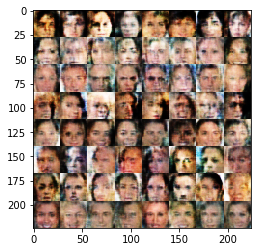

Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.8789
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 2.6119
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.5837
(64, 28, 28, 3)


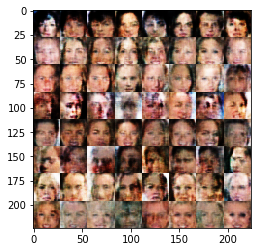

Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 4.8128
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 4.1171
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.0113
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 2.3054
(64, 28, 28, 3)


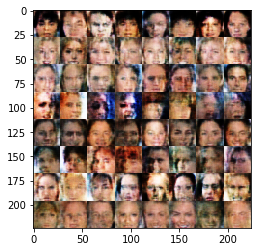

Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 4.1150
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 2.9053
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 2.1116
(64, 28, 28, 3)


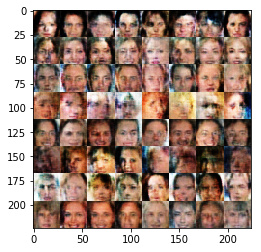

Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 3.3646
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 2.6577
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.9113
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 2.6481
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 2.6488
(64, 28, 28, 3)


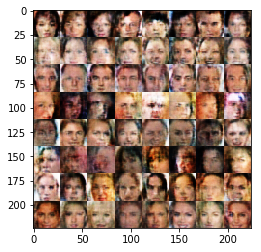

Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 2.1320
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 2.0895
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.7857
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 4.9563
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.9621
(64, 28, 28, 3)


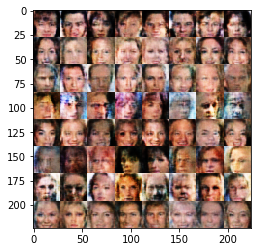

Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 2.1657
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 3.2430
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 4.7395
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 3.6829
(64, 28, 28, 3)


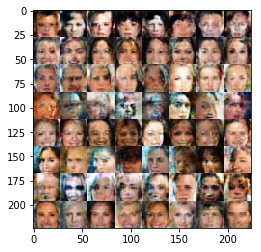

Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 2.1051
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 3.6127
Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 2.1808
(64, 28, 28, 3)


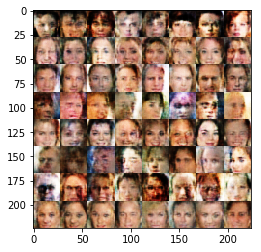

Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.9555
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.1802
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.8385
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.6187
(64, 28, 28, 3)


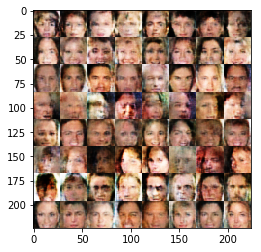

Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.9677
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 3.4098
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 2.4001
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.5928
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.6995
(64, 28, 28, 3)


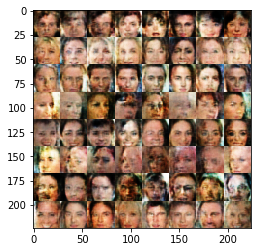

Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 2.9653
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.6578
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 2.5626
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.5698
(64, 28, 28, 3)


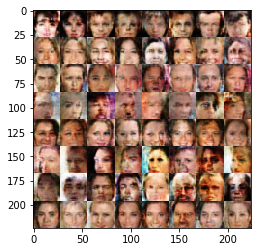

Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 2.2343
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 3.6156
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 2.7935
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 3.5345
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.2817
(64, 28, 28, 3)


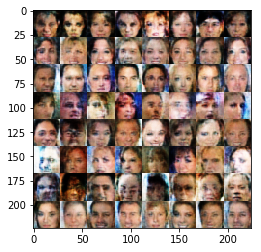

Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 3.4718
Epoch 1/1... Discriminator Loss: 0.4792... Generator Loss: 2.5008
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.4333
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.9578
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.3637
(64, 28, 28, 3)


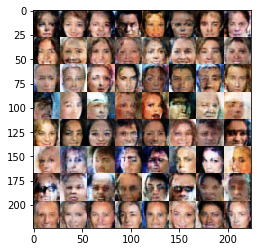

Epoch 1/1... Discriminator Loss: 0.4587... Generator Loss: 2.8168
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 2.7746
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.0724
(64, 28, 28, 3)


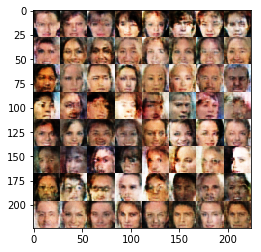

Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 2.3150
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 2.7634
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 3.1637
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.5350
(64, 28, 28, 3)


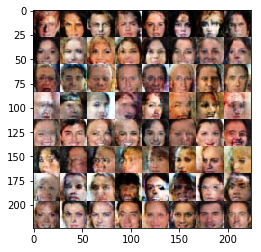

Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.9859
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.5813
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.3912
(64, 28, 28, 3)


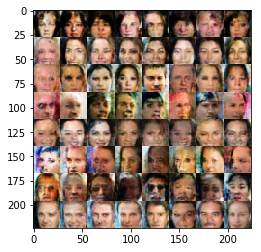

Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 2.8839
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.5672
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 2.3680
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.2219
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 2.5652
(64, 28, 28, 3)


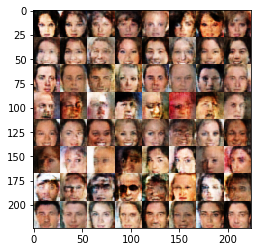

Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 2.8254
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 2.2054
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 2.2766


In [37]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.